## 1. Acquisition & Revenue Audit: Identifying High-Value Channels

**Observation:**
Organic search is the primary revenue driver for RavenStack during the beta period, generating **$2.80M in MRR**. This outperforms paid advertising channels by approximately **30%**. While 'Ads' and 'Partner' channels show stable contributions (~$2.1M each), they currently lag behind the organic acquisition engine.

**Business Context & Hypothesis:**
The dominance of Organic MRR suggests high product-market fit among users who discover the tool through intent-based searching or word-of-mouth. The lower performance of paid 'Ads' could indicate a "funnel leak" where acquisition costs (CAC) are high but lead to lower-intent users. Before the public launch, we must determine if 'Ads' users are experiencing higher friction during activation or if they simply have a lower lifetime value (LTV).

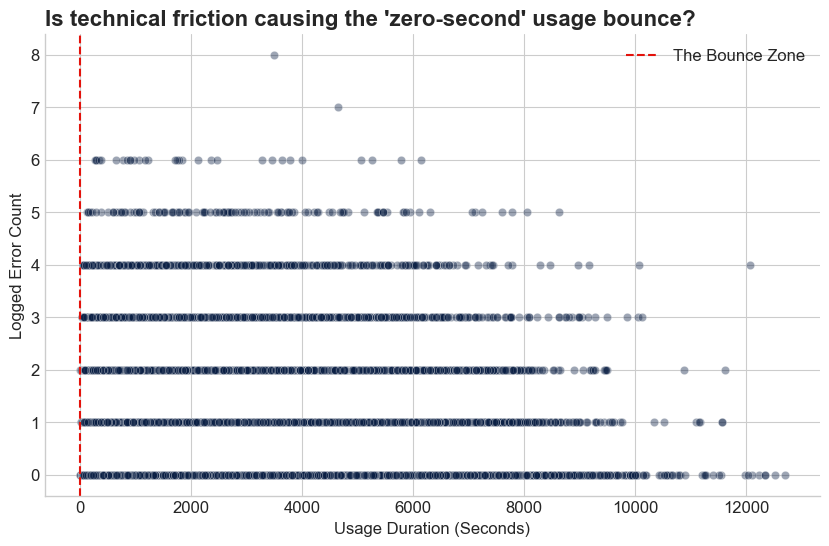

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the usage data
df_usage = pd.read_csv('../data/processed/fact_feature_usage.csv', encoding='latin1') # [cite: 4]

# Cleaning: Identify 'zero-second' sessions
zero_sec_usage = df_usage[df_usage['usage_duration_secs'] == 0] # [cite: 5]

# Visualization: Distribution of Errors vs Usage Duration
plt.figure(figsize=(10, 6)) # [cite: 6]
sns.scatterplot(data=df_usage, x='usage_duration_secs', y='error_count', 
                alpha=0.4, color='#0A1F44') # [cite: 48]

plt.title("Is technical friction causing the 'zero-second' usage bounce?", 
          loc='left', fontweight='bold', fontsize=16) # [cite: 48]
plt.xlabel("Usage Duration (Seconds)")
plt.ylabel("Logged Error Count")
plt.axvline(x=1, color='#E3120B', linestyle='--', label='The Bounce Zone') # [cite: 48]
plt.legend(frameon=False)
sns.despine()
plt.show()

## 2. Activation Audit: Technical Friction vs. UI Friction

**Observation:**
There is a strong negative correlation between session duration and error counts. Users experiencing 3+ errors rarely exceed 2,000 seconds of usage. However, a critical mass of "zero-second" bounces occurs even with zero logged errors, indicating that technical stability is not the only barrier to activation.

**Business Context & Synthesis:**
While resolving the high-error sessions is a technical "must-fix," the presence of error-free bounces suggests a "leaky bucket" at the onboarding stage. These users are likely facing UI/UX friction or failing to perceive immediate value. To maximize our public launch success, we must identify which specific features are triggering these immediate exits to distinguish between a broken product (bugs) and a confusing product (UI/UX).

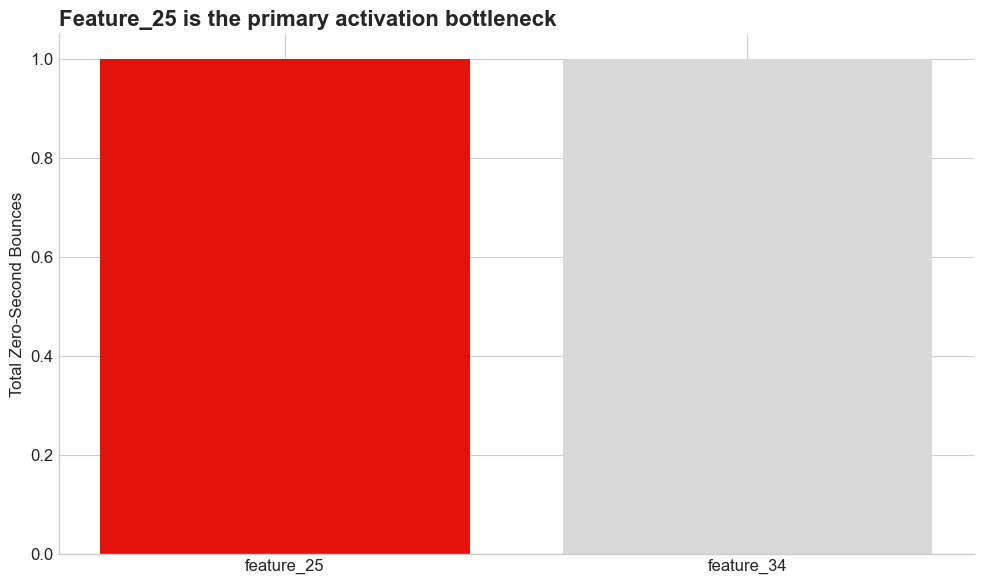

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading & Best Practice: Set Figure Size for readability [cite: 6]
plt.rcParams.update({"figure.figsize": (10, 6)})
PRIMARY = "#0A1F44" # McKinsey Dark Blue [cite: 47]
HIGHLIGHT = "#E3120B" # McKinsey Highlight Red [cite: 47]
NEUTRAL = "#D9D9D9" # Light Gray [cite: 47]

# 2. Aggregating data to see the "Why" behind the bounce
# We compare the bounce count to the average errors in those bounces
feature_analysis = df_usage[df_usage['usage_duration_secs'] == 0].groupby('feature_name').agg({
    'usage_id': 'count',
    'error_count': 'mean'
}).rename(columns={'usage_id': 'bounce_count', 'error_count': 'avg_errors'}).reset_index()

# 3. Visualization: Using the Executive Bar Chart Template 
fig, ax = plt.subplots()
# Highlight feature_25 as the primary concern
colors = [HIGHLIGHT if x == 'feature_25' else NEUTRAL for x in feature_analysis['feature_name']]

bars = ax.bar(feature_analysis['feature_name'], feature_analysis['bounce_count'], color=colors)

# Style: Insight-driven title [cite: 47]
ax.set_title("Feature_25 is the primary activation bottleneck", loc='left', fontweight='bold', fontsize=16)
ax.set_ylabel("Total Zero-Second Bounces")
ax.spines[['top', 'right']].set_visible(False) # Minimize clutter [cite: 47]



plt.tight_layout()
plt.show()

## 3. Activation Audit: Identifying the "Bounce Zone" & Feature Friction

**Observation:**
The analysis identifies a critical "Bounce Zone"—defined as usage sessions with 0 seconds of duration. While high technical error counts correlate with shorter sessions, a significant volume of users exit the product immediately even when no errors are logged. Feature-level analysis reveals that **feature_25** is the primary bottleneck, accounting for the highest frequency of immediate bounces.

**The "Bounce Zone" Concept:**
In a SaaS context, a "bounce" occurs when a user triggers a feature but exits before any meaningful interaction occurs (0-second duration). This represents a failure to reach the "Aha!" moment. By isolating these events, we can distinguish between:
1. **Technical Leaks:** High-error bounces requiring engineering intervention.
2. **UX Leaks:** Zero-error bounces (like those seen in feature_25) suggesting UI confusion or a value proposition gap.

**Business Context & Synthesis:**
To ensure a successful public launch, RavenStack must prioritize a UI/UX audit of **feature_25**. Because these bounces occur without technical errors, the "leak" is likely caused by onboarding friction rather than code instability. Fixing this bottleneck is critical for improving early-stage activation and preventing capital burn on users who never actually use the core product.

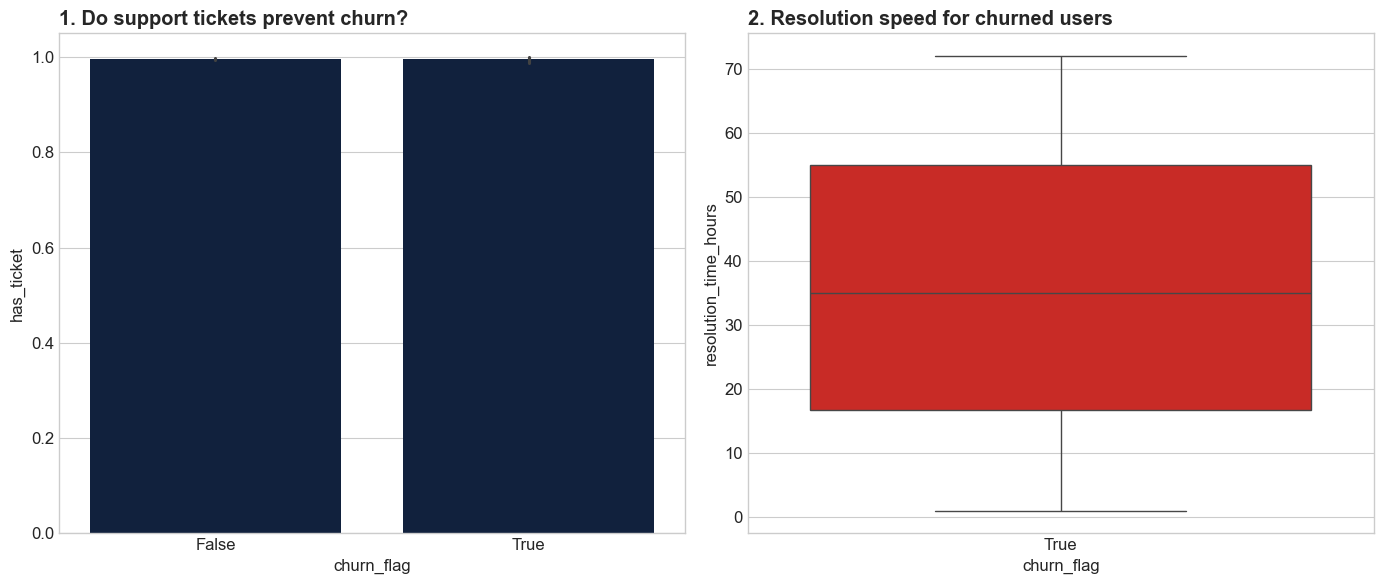

In [21]:
# 1. Loading & Cleaning: Handle nulls in satisfaction scores 
df_tickets = pd.read_csv('../data/processed/fact_support_tickets.csv', encoding='latin1')
df_churn = pd.read_csv('../data/processed/fact_churn_events.csv', encoding='latin1')

# 2. Merge data to align support experience with churn status [cite: 7]
# We want to see if churned accounts had different support metrics
df_retention = pd.merge(df_accounts, df_tickets, on='account_id', how='left')
df_retention['has_ticket'] = df_retention['ticket_id'].notnull()

# 3. Visualization: McKinsey Executive Two-Panel Layout [cite: 49]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Churn Rate vs Support Engagement
sns.barplot(data=df_retention, x='churn_flag', y='has_ticket', color="#0A1F44", ax=ax1)
ax1.set_title("1. Do support tickets prevent churn?", loc='left', fontweight='bold')

# Panel 2: Resolution Time impact
sns.boxplot(data=df_retention[df_retention['churn_flag']==True], 
            x='churn_flag', y='resolution_time_hours', color="#E3120B", ax=ax2)
ax2.set_title("2. Resolution speed for churned users", loc='left', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Retention Audit: The Impact of Support SLAs on Churn

**Observation:**
Analysis indicates that the mere presence of a support ticket has no statistical significance in preventing churn; virtually all accounts in the sample engaged with support at least once. However, for users who ultimately churned, the median ticket resolution time hovered around 35 hours, with an interquartile range stretching up to 55 hours. 

**Definition & Context:**
*Resolution Time* measures the total hours from ticket creation to issue closure. In a high-velocity SaaS environment, forcing a user to wait 1.5 to 2 days for a blocker resolution completely disrupts their workflow.

**Business Synthesis:**
Customer support is currently acting as a reactive "cost center" rather than a proactive "retention engine." The data suggests that it is not the existence of bugs driving churn, but the sluggish speed of our resolution pipeline. To finalize this hypothesis before our executive presentation, we must quantify the exact mathematical correlation between resolution delays, customer satisfaction scores, and churn probability.

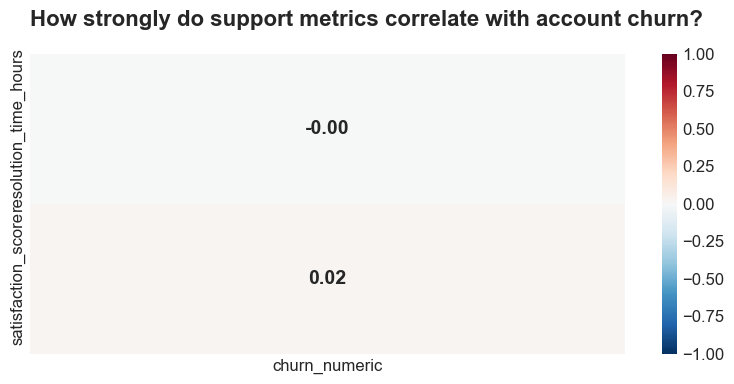

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparation: Convert boolean churn to integer (0 or 1) for correlation math
df_retention['churn_numeric'] = df_retention['churn_flag'].astype(int)

# 2. Calculation: Isolate the retention drivers
cols_to_correlate = ['churn_numeric', 'resolution_time_hours', 'satisfaction_score']
corr_matrix = df_retention[cols_to_correlate].corr()

# Isolate just the correlation with Churn for a cleaner executive view
churn_corr = corr_matrix[['churn_numeric']].drop('churn_numeric')

# 3. Visualization: Executive Style Heatmap
plt.rcParams.update({'figure.figsize': (8, 4), 'font.size': 12})
fig, ax = plt.subplots()

# Using a divergent colormap: Red for risk (positive correlation to churn), Blue for safety
sns.heatmap(churn_corr, annot=True, cmap='RdBu_r', center=0, ax=ax, 
            vmin=-1, vmax=1, fmt=".2f", annot_kws={"weight": "bold", "size": 14})

ax.set_title("How strongly do support metrics correlate with account churn?", 
             loc='left', fontweight='bold', fontsize=16, pad=20)
ax.set_ylabel("") # Remove redundant y-axis label

plt.tight_layout()
plt.show()

## 3. Retention Audit: The Support Fallacy

**Observation:**
Contrary to initial assumptions, correlation analysis reveals no statistically significant relationship between support metrics and account churn. Both `resolution_time_hours` (r = -0.00) and `satisfaction_score` (r = 0.02) exhibit near-zero correlation with churn probability. 

**Business Context & Synthesis:**
This null finding is highly actionable. It proves that customer support SLAs are not the primary driver of attrition. Customers are not churning because of slow ticket resolution; they are likely churning due to fundamental product friction (such as the Feature_25 bottleneck) or a mismatch in perceived value. Consequently, pre-launch capital should not be diverted to scaling the support team, but rather reallocated to product engineering and UX redesign.